In [2]:
import argparse
import json
import os
import numpy as np
import torch
import time
from copy import deepcopy
import random
import matplotlib.cm
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display 
import psutil
import sys
import json

In [3]:
def load(pathToCapture, smartpoolingInAR=False):
    dir_name = "smartpooling_importance" + ("_ar" if smartpoolingInAR else "")
    full_dir_name = os.path.join(pathToCapture, dir_name)
    filename = sorted([f for f in os.listdir(full_dir_name) if os.path.isfile(os.path.join(full_dir_name, f)) and f.startswith(dir_name)])[0]
    filename_suffix = filename.split(dir_name)[1]

    batchData = torch.load(os.path.join(full_dir_name, "batchData" + filename_suffix))
    importance = torch.load(os.path.join(full_dir_name, dir_name + filename_suffix))
    phone_align = torch.load(os.path.join(pathToCapture, "phone_align", "phone_align" + filename_suffix))
    phone_to_id = torch.load(os.path.join(os.path.dirname(pathToCapture), "labelsToIdDict.pt"))
    id_to_phone = {phone_id : phone for phone, phone_id in phone_to_id.items()}

    return batchData, importance, phone_align, id_to_phone

In [1]:
def visualize(batchData, importance, phone_align, id_to_phone):
    half_size = 16
    text_offset = 3
    DOWNSAMPLING = 160
    x_axis_zoom_out = 16
    lines_to_visualize = min(16, importance.shape[0])

    batchData = batchData[:lines_to_visualize]
    importance = importance[:lines_to_visualize]
    phone_align = phone_align[:lines_to_visualize]

    def draw_text(draw, x, y, text, font):
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            draw.text((x+dx, y+dy), text, font=font, fill='black', align="left")
        draw.text((x, y), text, font=font, fill='white', align="left")

    try:
        #font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 14)
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 14)
    except:
        font = ImageFont.load_default()

    with torch.no_grad():        
        importance = np.array(importance.numpy()*255, dtype=np.int32).repeat(int(batchData.shape[2]/importance.shape[1]/x_axis_zoom_out), axis=1)
        importance = importance.repeat(2*half_size, axis=0)
        img = Image.fromarray(importance).convert('RGB')

        draw = ImageDraw.Draw(img)
        for b in range(batchData.shape[0]):
            for i in range(batchData.shape[2]-1):
                draw.line([(i / x_axis_zoom_out, round(half_size * (2*b + 1 + batchData[b, 0, i].item()))), ((i+1) / x_axis_zoom_out, round(half_size * (2*b + 1 + batchData[b, 0, i+1].item())))], fill='blue', width=1)
        
        for b in range(phone_align.shape[0]):
            last = -1
            for i in range(phone_align.shape[1]):
                if last != phone_align[b,i]:
                    draw_text(draw, i * DOWNSAMPLING / x_axis_zoom_out + text_offset, 2 * b * half_size + text_offset, id_to_phone[phone_align[b,i].item()], font)
                    draw.line([(i * DOWNSAMPLING / x_axis_zoom_out, 2 * b * half_size), (i * DOWNSAMPLING / x_axis_zoom_out, 2 * (b + 1) * half_size)], fill='red', width=1)
                last = phone_align[b,i]

        #img.save(os.path.join(args.pathToCapture, "smartpooling_importance.png"))
        display(img)

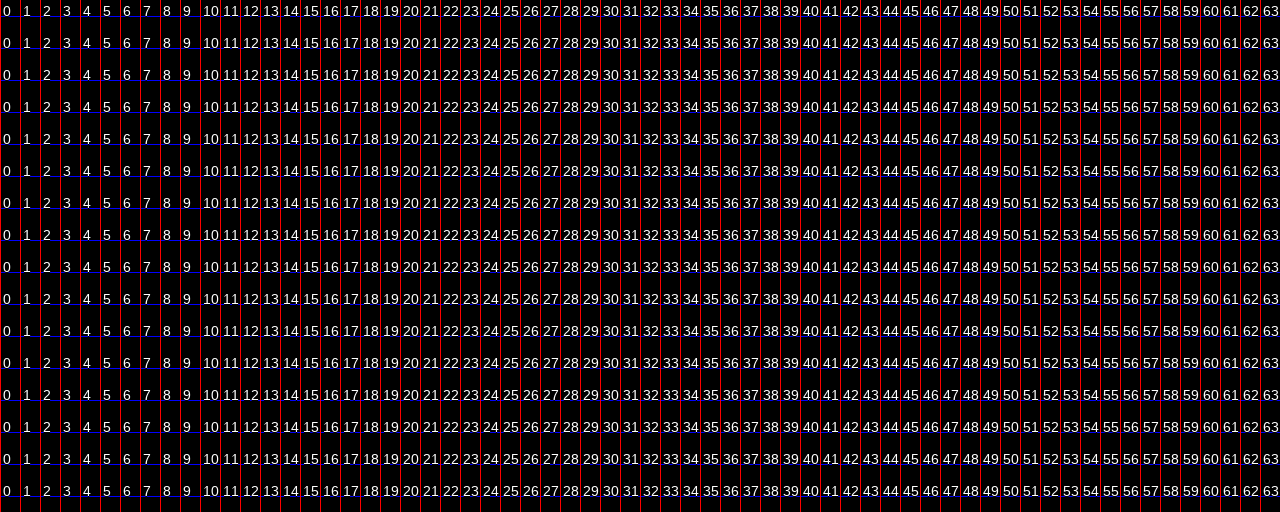

In [5]:
batchData = torch.zeros(32,1, 128 * 160)
importance = torch.zeros(32,128)
phone_align = torch.arange(70).repeat_interleave(128//70 + 1, 0).repeat(32, 1)
phone_align = phone_align[:,:128]
id_to_phone = {i : str(i) for i in range(100)}


visualize(batchData, importance, phone_align, id_to_phone)

# 5_normal_window_7

## Self-supervised @ 135

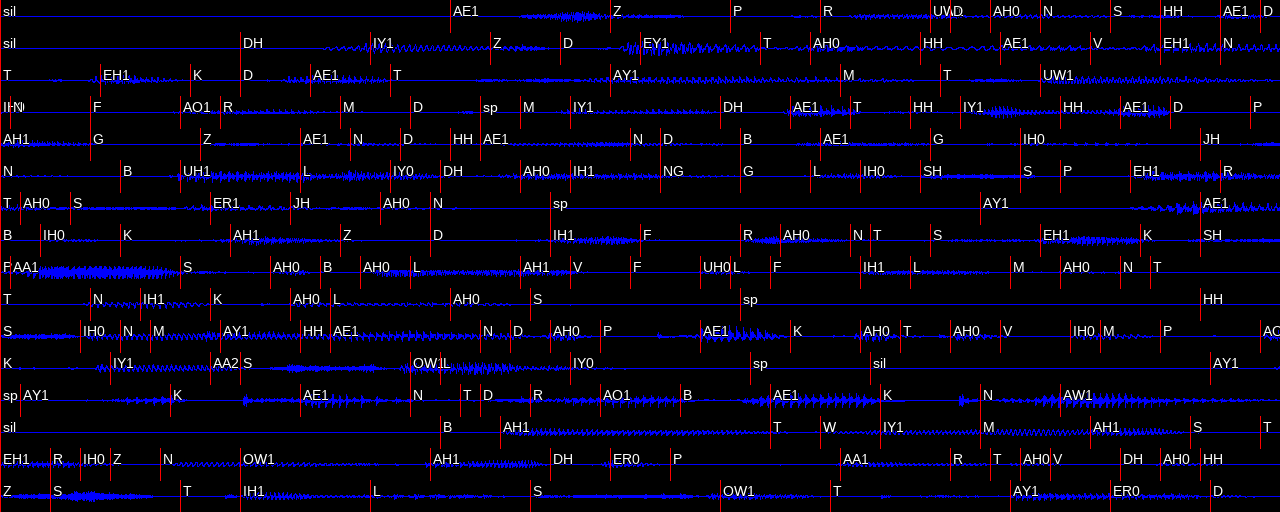

In [6]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_normal_window_7/capture/135")
visualize(batchData, importance, phone_align, id_to_phone)

## Supervised encoder only @ 10

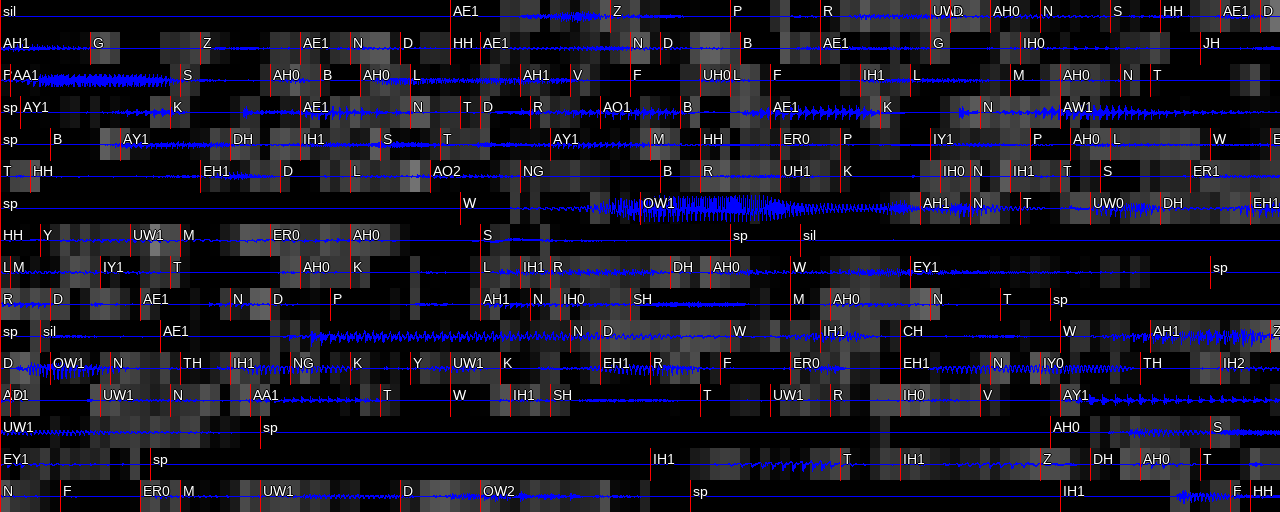

In [10]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_normal_window_7/lineval_onenc_no_pretraining_135/capture/-1")
visualize(batchData, importance, phone_align, id_to_phone)

## Supervised @ 10

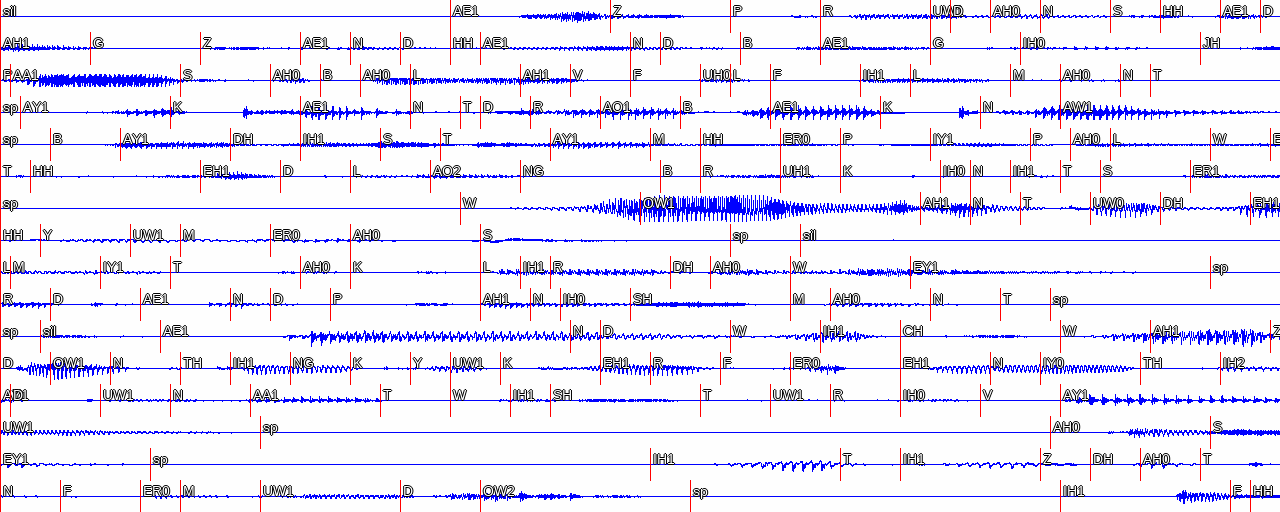

In [11]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_normal_window_7/lineval_no_pretraining_135/capture/-1")
visualize(batchData, importance, phone_align, id_to_phone)

## Supervised @ 50 - 3 runs

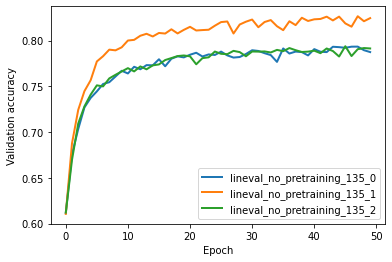

In [37]:
common_prefix = "/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_normal_window_7/lineval_no_pretraining_135_"
dir_name = os.path.dirname(common_prefix)
files = sorted([os.path.join(dir_name, f) for f in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, f)) and f.startswith(os.path.basename(common_prefix))])

plt.figure()
for i, f in enumerate(files):
    logs = {}
    try:
        with open(os.path.join(f, 'checkpoint_logs.json'), 'rb') as file:
            logs = json.load(file)
    except Exception as e:
        print(f"WARNING: failed to load log: {e}")

    Y = np.array(logs["locAcc_val"])
    X = np.arange(Y.shape[0])
    plt.plot(X, Y, linewidth=2)

plt.ylabel("Validation accuracy")
plt.xlabel("Epoch")
plt.legend([os.path.basename(file) for file in files])
plt.show()


## Supervised - Hardcoded averaging @ 50

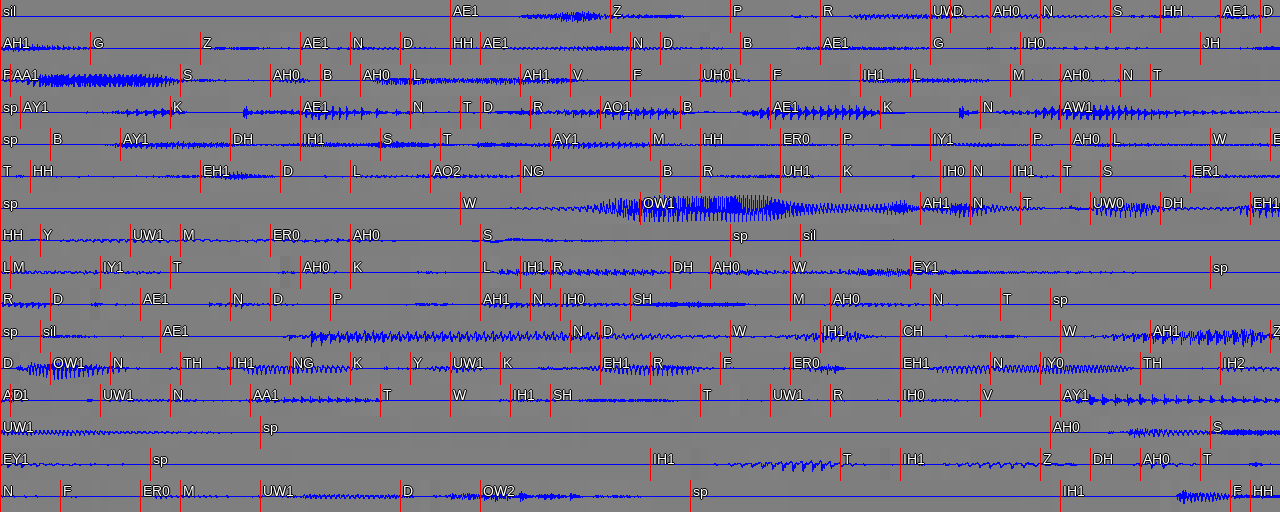

In [13]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_hardcoded/lineval_no_pretraining_50/capture/50")
visualize(batchData, importance, phone_align, id_to_phone)

10


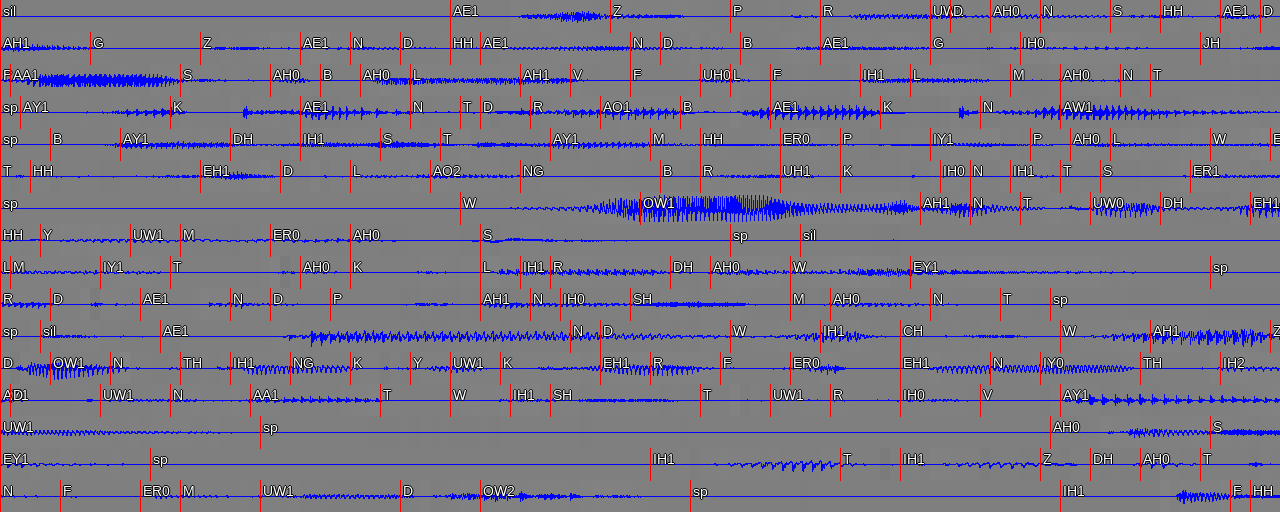

20


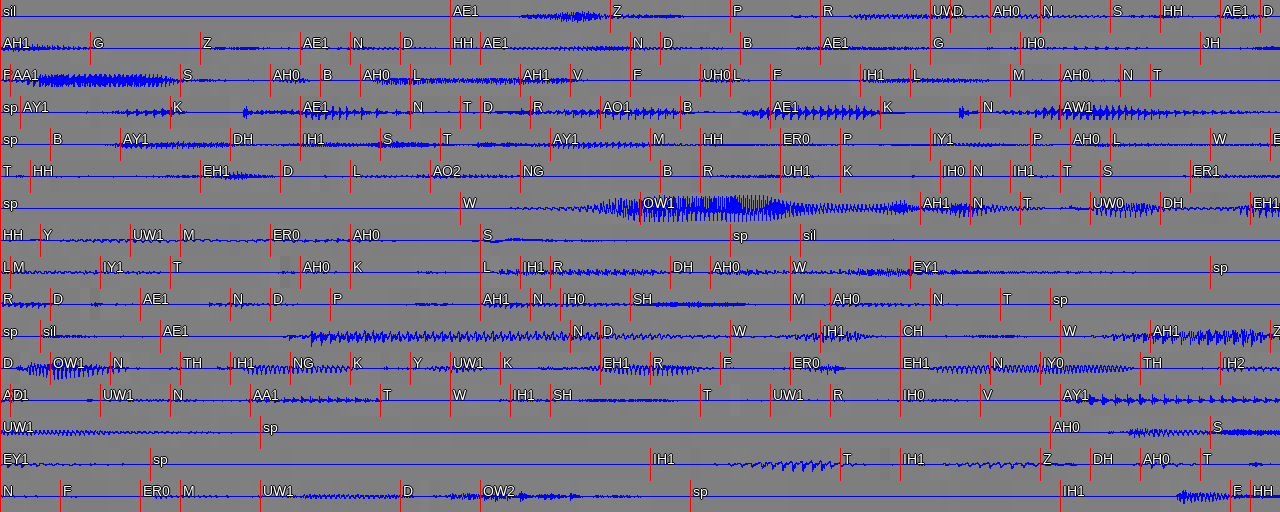

30


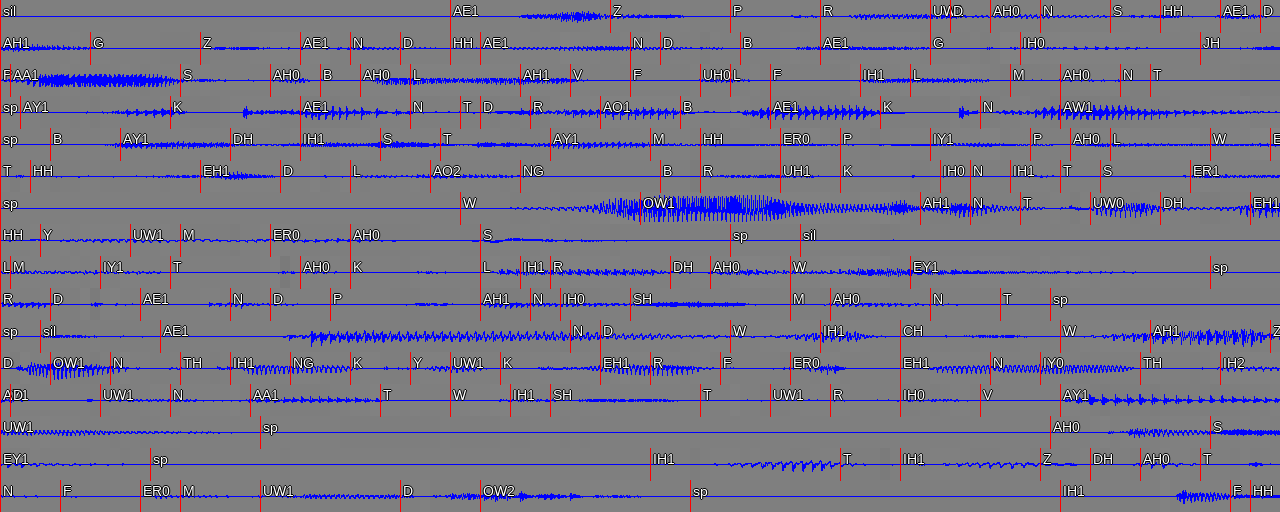

40


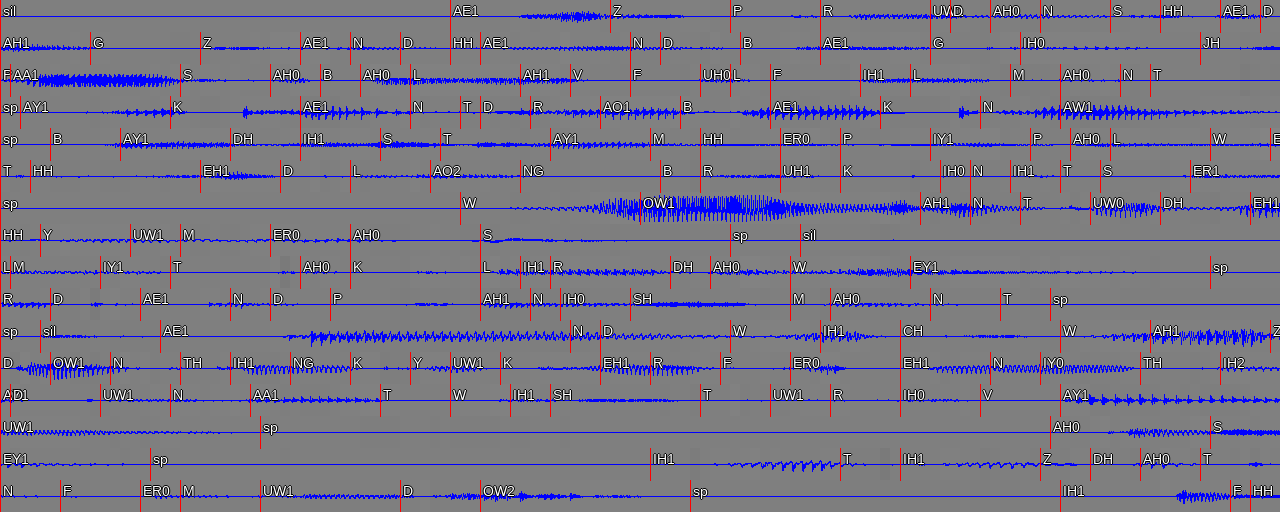

50


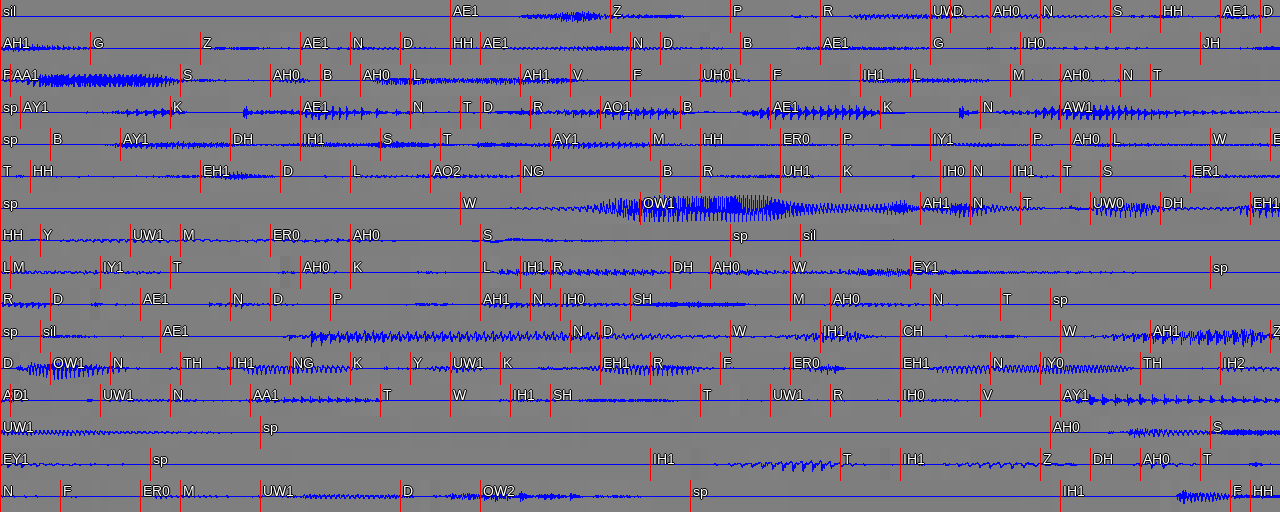

In [12]:
for i in [10,20,30,40,50]:
    batchData, importance, phone_align, id_to_phone = load(os.path.join("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_hardcoded/lineval_no_pretraining_50/capture", str(i)))
    print(i)
    visualize(batchData, importance, phone_align, id_to_phone)

In [7]:
for i in [10,20,30,40,50]:
    batchData, importance, phone_align, id_to_phone = load(os.path.join("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_hardcoded/lineval_no_pretraining_50/capture", str(i)))
    print(i)
    print(importance[0,:16])
    #visualize(batchData, importance, phone_align, id_to_phone)

10
tensor([0.5004, 0.5002, 0.5004, 0.5005, 0.5005, 0.5004, 0.5003, 0.5003, 0.5003,
        0.5003, 0.5003, 0.5005, 0.5004, 0.5004, 0.5005, 0.5005])
20
tensor([0.5002, 0.5000, 0.5002, 0.5002, 0.5003, 0.5002, 0.5002, 0.5001, 0.5001,
        0.5001, 0.5001, 0.5002, 0.5003, 0.5002, 0.5003, 0.5003])
30
tensor([0.5007, 0.5005, 0.5007, 0.5006, 0.5007, 0.5006, 0.5006, 0.5006, 0.5006,
        0.5005, 0.5005, 0.5007, 0.5008, 0.5007, 0.5007, 0.5007])
40
tensor([0.5004, 0.5002, 0.5004, 0.5004, 0.5005, 0.5004, 0.5004, 0.5002, 0.5003,
        0.5002, 0.5002, 0.5004, 0.5005, 0.5004, 0.5005, 0.5004])
50
tensor([0.5004, 0.5004, 0.5005, 0.5006, 0.5006, 0.5005, 0.5004, 0.5003, 0.5004,
        0.5003, 0.5004, 0.5005, 0.5005, 0.5004, 0.5006, 0.5005])


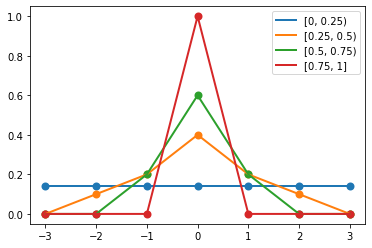

In [14]:
windows = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                        [0.0, 0.1, 0.2, 0.4, 0.2, 0.1, 0.0], 
                        [0.0, 0.0, 0.2, 0.6, 0.2, 0.0, 0.0], 
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])
windows /= windows.sum(1, keepdim=True)
X = torch.arange(-3,4)

plt.figure()
for i in range(windows.shape[0]):
    Y = windows[i]
    plt.plot(X,Y, linewidth=2)
    plt.scatter(X,Y, linewidth=2)
legend = ["[0, 0.25)", "[0.25, 0.5)", "[0.5, 0.75)", "[0.75, 1]"]
plt.legend(legend)
plt.show()

In [6]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_hardcoded_19/lineval_no_pretraining_50/capture/50")
print(i)
print(importance[0,:16])
#visualize(batchData, importance, phone_align, id_to_phone)

10
tensor([0.5069, 0.5069, 0.5069, 0.5068, 0.5069, 0.5068, 0.5068, 0.5067, 0.5068,
        0.5069, 0.5068, 0.5066, 0.5069, 0.5069, 0.5069, 0.5068])


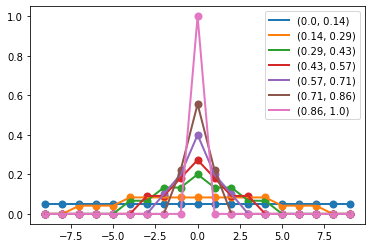

In [13]:
window_size = 19
windows = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1 ,1 ,1,1,1,1,1,1,1,1, 1], 
                        [0.0, 0.0, 1,1,1,2,2,2,2,2, 2,2,2,2,1, 1,1, 0.0, 0.0], 
                        [0.0, 0.0, 0.0, 0,0,1,1,2,2,3,2, 2,1,1,0, 0,0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0,0,0,1,1,2,3, 2,1,1,0,0, 0,0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0,0,0,0,1,2,4, 2,1,0,0,0, 0,0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0,0,0,0,0,2,5, 2,0,0,0,0, 0,0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0,0,0,0,0,0,1, 0,0,0,0,0, 0,0.0, 0.0, 0.0]])
windows /= windows.sum(1, keepdim=True)
X = torch.arange(-(window_size//2), window_size//2+1)

plt.figure()
for i in range(windows.shape[0]):
    Y = windows[i]
    plt.plot(X,Y, linewidth=2)
    plt.scatter(X,Y, linewidth=2)

ends = (torch.arange(windows.shape[0]+1).double() / windows.shape[0]).numpy()
legend = [(round(ends[i], 2), round(ends[i+1], 2)) for i in range(windows.shape[0])]

plt.legend(legend)
plt.show()

In [15]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_hardcoded_19_2/lineval_no_pretraining_50/capture/50")
print(i)
print(importance[0,:16])
#visualize(batchData, importance, phone_align, id_to_phone)

6
tensor([0.4900, 0.4901, 0.4899, 0.4901, 0.4901, 0.4901, 0.4900, 0.4899, 0.4901,
        0.4900, 0.4898, 0.4899, 0.4901, 0.4900, 0.4901, 0.4901])


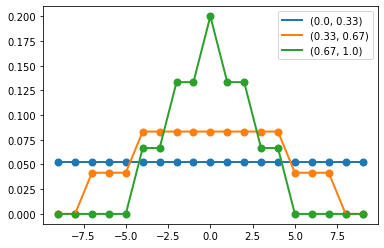

In [16]:
window_size = 19
windows = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1 ,1 ,1,1,1,1,1,1,1,1, 1], 
                        [0.0, 0.0, 1,1,1,2,2,2,2,2, 2,2,2,2,1, 1,1, 0.0, 0.0], 
                        [0.0, 0.0, 0.0, 0,0,1,1,2,2,3,2, 2,1,1,0, 0,0.0, 0.0, 0.0]])
windows /= windows.sum(1, keepdim=True)
X = torch.arange(-(window_size//2), window_size//2+1)

plt.figure()
for i in range(windows.shape[0]):
    Y = windows[i]
    plt.plot(X,Y, linewidth=2)
    plt.scatter(X,Y, linewidth=2)

ends = (torch.arange(windows.shape[0]+1).double() / windows.shape[0]).numpy()
legend = [(round(ends[i], 2), round(ends[i+1], 2)) for i in range(windows.shape[0])]

plt.legend(legend)
plt.show()

In [5]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_hardcoded_19_3/lineval_no_pretraining_50/capture/50")
print(importance[0,:16])

tensor([0.5003, 0.5004, 0.5005, 0.5004, 0.5003, 0.5003, 0.5003, 0.5004, 0.5004,
        0.5002, 0.5002, 0.5004, 0.5004, 0.5004, 0.5004, 0.5004])


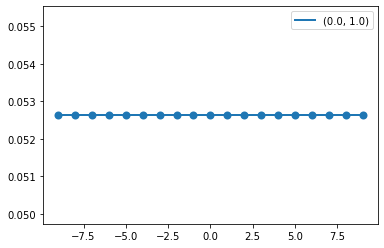

In [6]:
window_size = 19
windows = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1 ,1 ,1,1,1,1,1,1,1,1, 1]])
windows /= windows.sum(1, keepdim=True)
X = torch.arange(-(window_size//2), window_size//2+1)

plt.figure()
for i in range(windows.shape[0]):
    Y = windows[i]
    plt.plot(X,Y, linewidth=2)
    plt.scatter(X,Y, linewidth=2)

ends = (torch.arange(windows.shape[0]+1).double() / windows.shape[0]).numpy()
legend = [(round(ends[i], 2), round(ends[i+1], 2)) for i in range(windows.shape[0])]

plt.legend(legend)
plt.show()

In [8]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_hardcoded_31/lineval_no_pretraining_10/capture/10")
print(importance[0,:16])

tensor([0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014,
        0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014])


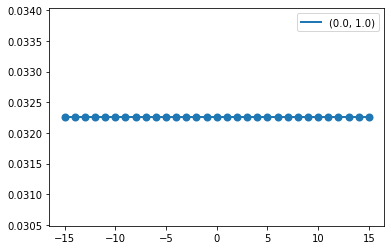

In [9]:
window_size = 31
windows = torch.ones(1, window_size, device=X.device)
windows /= windows.sum(1, keepdim=True)
X = torch.arange(-(window_size//2), window_size//2+1)

plt.figure()
for i in range(windows.shape[0]):
    Y = windows[i]
    plt.plot(X,Y, linewidth=2)
    plt.scatter(X,Y, linewidth=2)

ends = (torch.arange(windows.shape[0]+1).double() / windows.shape[0]).numpy()
legend = [(round(ends[i], 2), round(ends[i+1], 2)) for i in range(windows.shape[0])]

plt.legend(legend)
plt.show()

Hardcoded 31,51,71,101,127

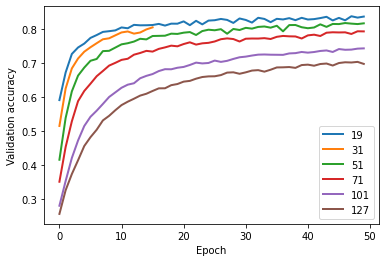

In [12]:
common_prefix = "/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_hardcoded"
numbers = [19, 31, 51, 71, 101, 127]
runs = ["5_hardcoded_19_3", "5_hardcoded_31_proper", "5_hardcoded_51_proper", "5_hardcoded_71_proper", "5_hardcoded_101_proper", "5_hardcoded_127_proper"]
names = ["/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/" + run + "/lineval_no_pretraining_50/checkpoint_logs.json" for run in runs]
#dir_name = os.path.dirname(common_prefix)
#files = sorted([os.path.join(dir_name, f) for f in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, f)) and f.startswith(os.path.basename(common_prefix))])

plt.figure()
for i, f in enumerate(names):
    logs = {}
    try:
        with open(f, 'rb') as file:
            logs = json.load(file)
    except Exception as e:
        print(f"WARNING: failed to load log: {e}")

    Y = np.array(logs["locAcc_val"])
    X = np.arange(Y.shape[0])
    plt.plot(X, Y, linewidth=2)

plt.ylabel("Validation accuracy")
plt.xlabel("Epoch")
plt.legend(numbers)
plt.show()


# Master thesis vis

In [29]:
def masterthesis(batchData, importance, phone_align, id_to_phone):
    half_size = 128
    text_offset = 3
    DOWNSAMPLING = 160
    x_axis_zoom_out = 8
    lines_to_visualize = min(2, importance.shape[0])

    batchData = batchData[:lines_to_visualize]
    importance = importance[:lines_to_visualize]
    phone_align = phone_align[:lines_to_visualize]

    with torch.no_grad():        
        importance = np.array(importance.numpy()*255, dtype=np.int32).repeat(int(batchData.shape[2]/importance.shape[1]/x_axis_zoom_out), axis=1)
        importance = importance.repeat(2*half_size, axis=0)
        importace = np.zeros_like(importance)
        #img = Image.fromarray(importance).convert('RGB')
        img = Image.new(mode="RGBA", size=(importance.shape[1], importance.shape[0]), color=(0,0,0,0))

        draw = ImageDraw.Draw(img)
        for b in range(batchData.shape[0]):
            for i in range(batchData.shape[2]-1):
                draw.line([(i / x_axis_zoom_out, round(half_size * (2*b + 1 + batchData[b, 0, i].item()))), ((i+1) / x_axis_zoom_out, round(half_size * (2*b + 1 + batchData[b, 0, i+1].item())))], fill='blue', width=1)

        #img.save("waveform.eps")
        img.save("waveform.png")
        display(img)

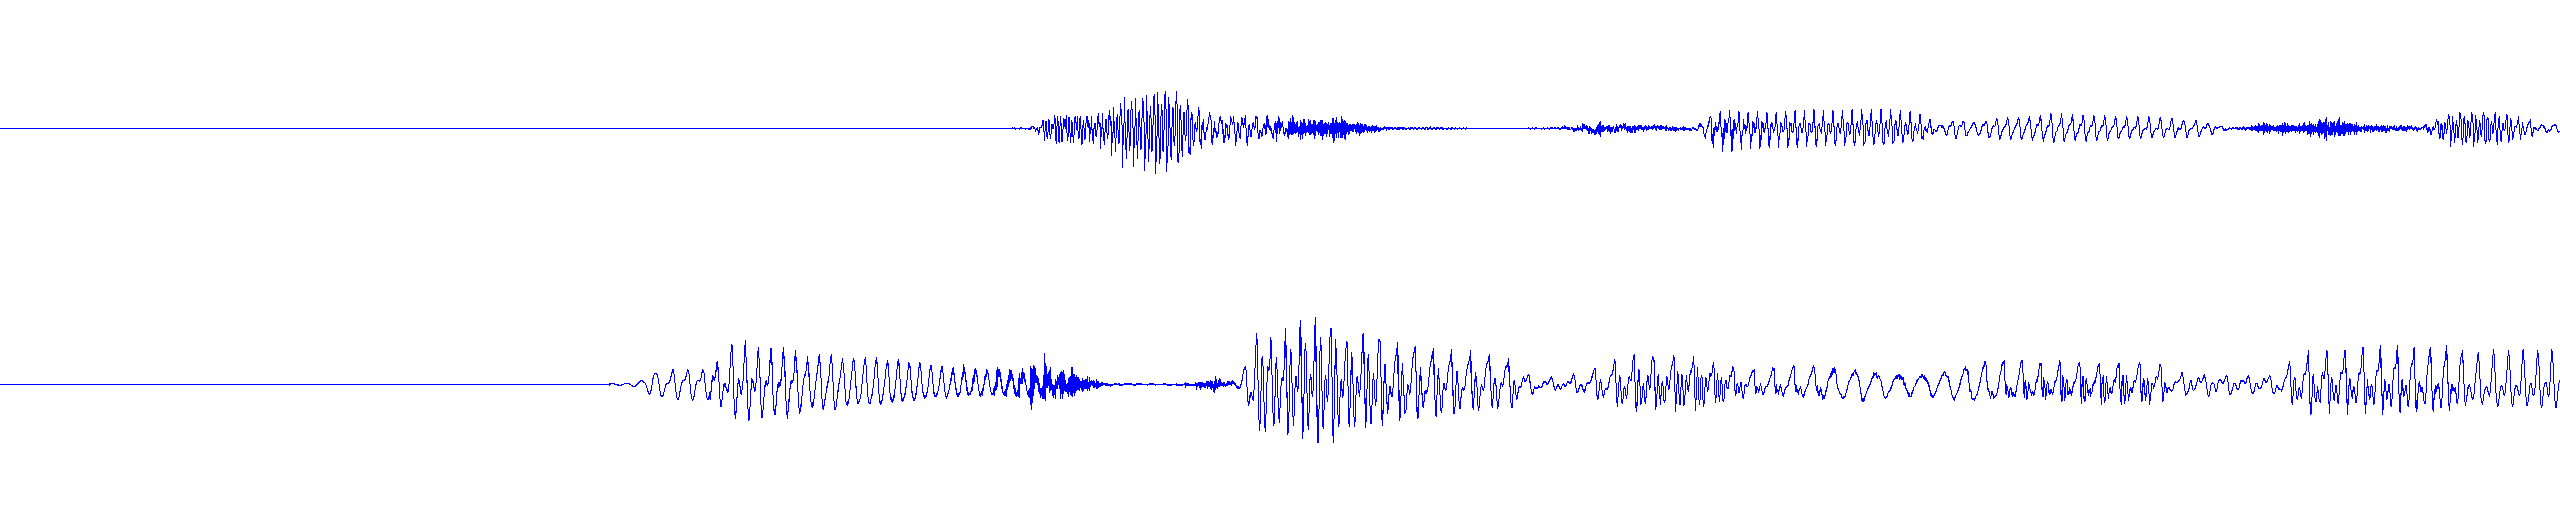

In [30]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_ar_normal_window_7_loss_001/capture/50", smartpoolingInAR=True)
masterthesis(batchData, importance, phone_align, id_to_phone)

# 5 ar window 7 @ 190

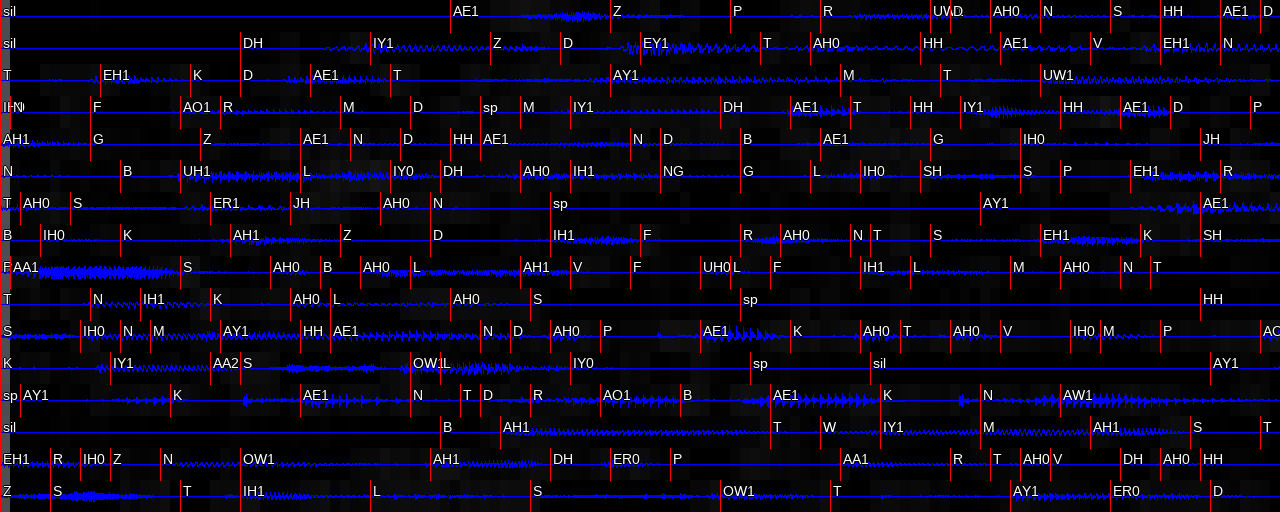

In [16]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_ar_normal_window_7/capture/190", smartpoolingInAR=True)
visualize(batchData, importance, phone_align, id_to_phone)

# 5 ar window 7 loss 0.1 average 0.5 @ 50

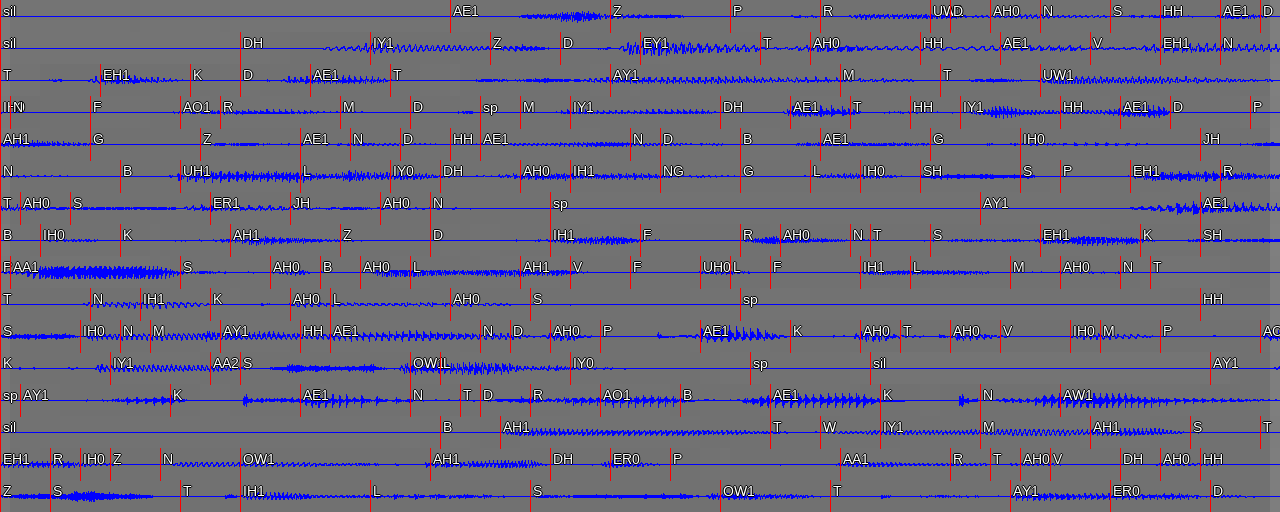

In [7]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_ar_normal_window_7_loss/capture/50", smartpoolingInAR=True)
visualize(batchData, importance, phone_align, id_to_phone)

# 5 ar window 7 loss 0.01 average 0.5 @ 50

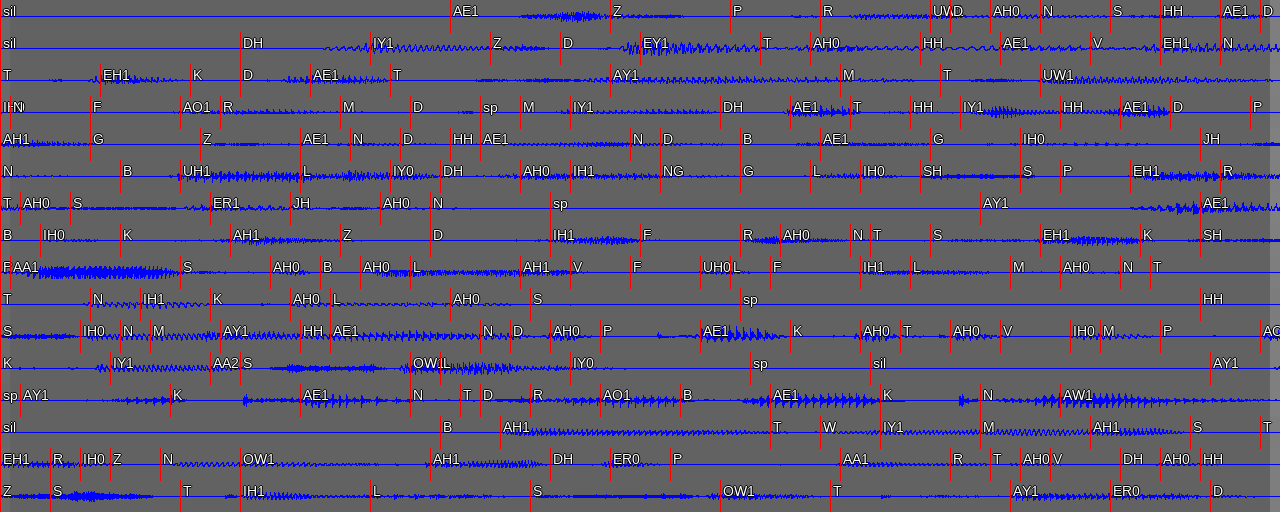

In [8]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_ar_normal_window_7_loss_001/capture/50", smartpoolingInAR=True)
visualize(batchData, importance, phone_align, id_to_phone)

# 5 ar window 7 loss 0.001 average 0.5 @ 100

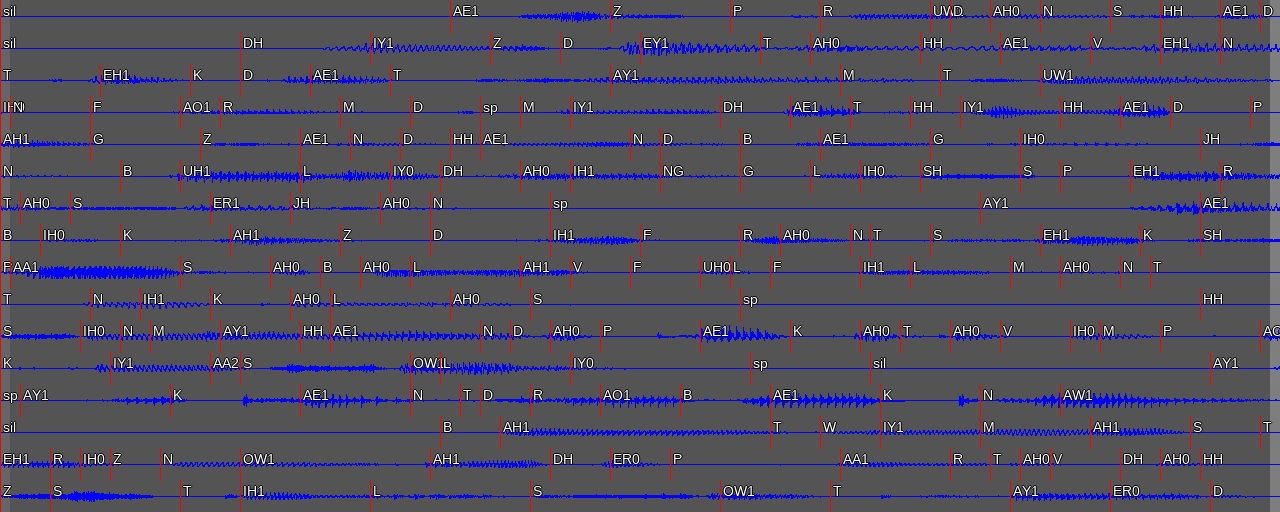

In [8]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_ar_normal_window_7_loss_0001/capture/100", smartpoolingInAR=True)
visualize(batchData, importance, phone_align, id_to_phone)

# 5 ar window 7 loss 0.0001 average 0.5 @ 30

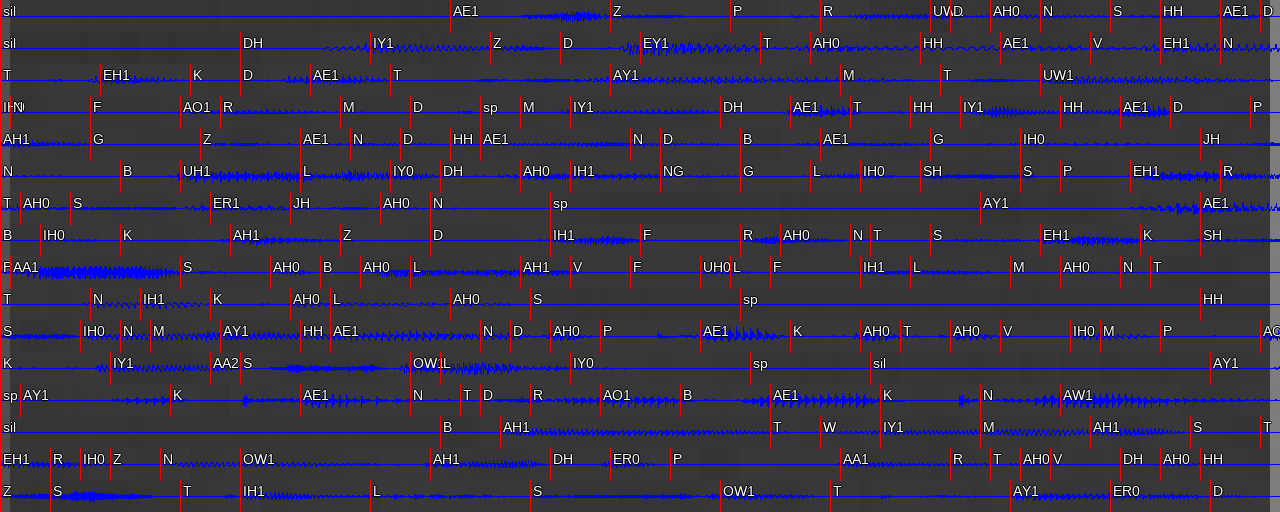

In [14]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_ar_normal_window_7_loss_00001/capture/20", smartpoolingInAR=True)
visualize(batchData, importance, phone_align, id_to_phone)

# 5 hardcoded supervised no pretraining @ 50

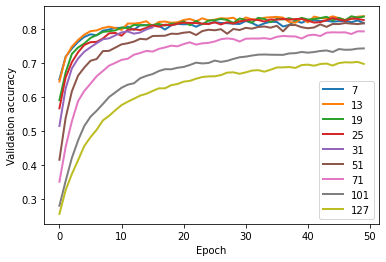

In [5]:
common_prefix = "/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/"
numbers = [7, 13, 19, 25, 31, 51, 71, 101, 127]
runs = ["5_hardcoded_7_proper_2", "5_hardcoded_13_proper_2", "5_hardcoded_19_proper", "5_hardcoded_25_proper_2", "5_hardcoded_31_proper", "5_hardcoded_51_proper", "5_hardcoded_71_proper", "5_hardcoded_101_proper", "5_hardcoded_127_proper"]
names = [common_prefix + run + "/lineval_no_pretraining_50/checkpoint_logs.json" for run in runs]
#dir_name = os.path.dirname(common_prefix)
#files = sorted([os.path.join(dir_name, f) for f in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, f)) and f.startswith(os.path.basename(common_prefix))])

plt.figure()
for i, f in enumerate(names):
    logs = {}
    try:
        with open(f, 'rb') as file:
            logs = json.load(file)
    except Exception as e:
        print(f"WARNING: failed to load log: {e}")

    Y = np.array(logs["locAcc_val"])
    X = np.arange(Y.shape[0])
    plt.plot(X, Y, linewidth=2)

plt.ylabel("Validation accuracy")
plt.xlabel("Epoch")
plt.legend(numbers)
plt.show()


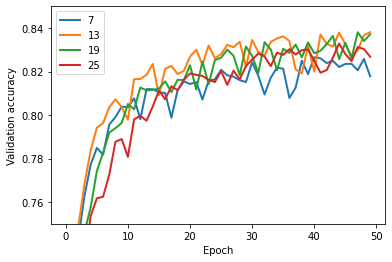

In [7]:
common_prefix = "/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/"
numbers = [7, 13, 19, 25]
runs = ["5_hardcoded_7_proper_2", "5_hardcoded_13_proper_2", "5_hardcoded_19_proper", "5_hardcoded_25_proper_2"]
names = [common_prefix + run + "/lineval_no_pretraining_50/checkpoint_logs.json" for run in runs]
#dir_name = os.path.dirname(common_prefix)
#files = sorted([os.path.join(dir_name, f) for f in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, f)) and f.startswith(os.path.basename(common_prefix))])

plt.figure()
for i, f in enumerate(names):
    logs = {}
    try:
        with open(f, 'rb') as file:
            logs = json.load(file)
    except Exception as e:
        print(f"WARNING: failed to load log: {e}")

    Y = np.array(logs["locAcc_val"])
    X = np.arange(Y.shape[0])
    plt.plot(X, Y, linewidth=2)

plt.ylabel("Validation accuracy")
plt.xlabel("Epoch")
plt.ylim((0.75, 0.85))
plt.legend(numbers)
plt.show()


# 5 hardcoded supervised no pretraining (encoder only) @ 50 

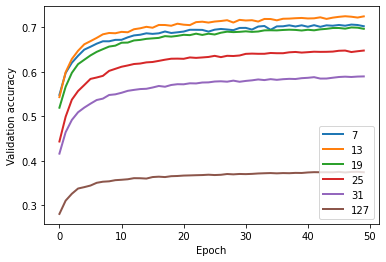

In [8]:
common_prefix = "/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/"
numbers = [7, 13, 19, 25, 31, 127]
runs = ["5_hardcoded_7_proper_3", "5_hardcoded_13_proper_3", "5_hardcoded_19_proper_3", "5_hardcoded_25_proper_3", "5_hardcoded_31_proper_3", "5_hardcoded_127_proper"]
names = [common_prefix + run + "/lineval_onenc_no_pretraining_50/checkpoint_logs.json" for run in runs]
#dir_name = os.path.dirname(common_prefix)
#files = sorted([os.path.join(dir_name, f) for f in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, f)) and f.startswith(os.path.basename(common_prefix))])

plt.figure()
for i, f in enumerate(names):
    logs = {}
    try:
        with open(f, 'rb') as file:
            logs = json.load(file)
    except Exception as e:
        print(f"WARNING: failed to load log: {e}")

    Y = np.array(logs["locAcc_val"])
    X = np.arange(Y.shape[0])
    plt.plot(X, Y, linewidth=2)

plt.ylabel("Validation accuracy")
plt.xlabel("Epoch")
plt.legend(numbers)
plt.show()

# 5 ar window 13 loss 0.01 average 0.5 @ 60

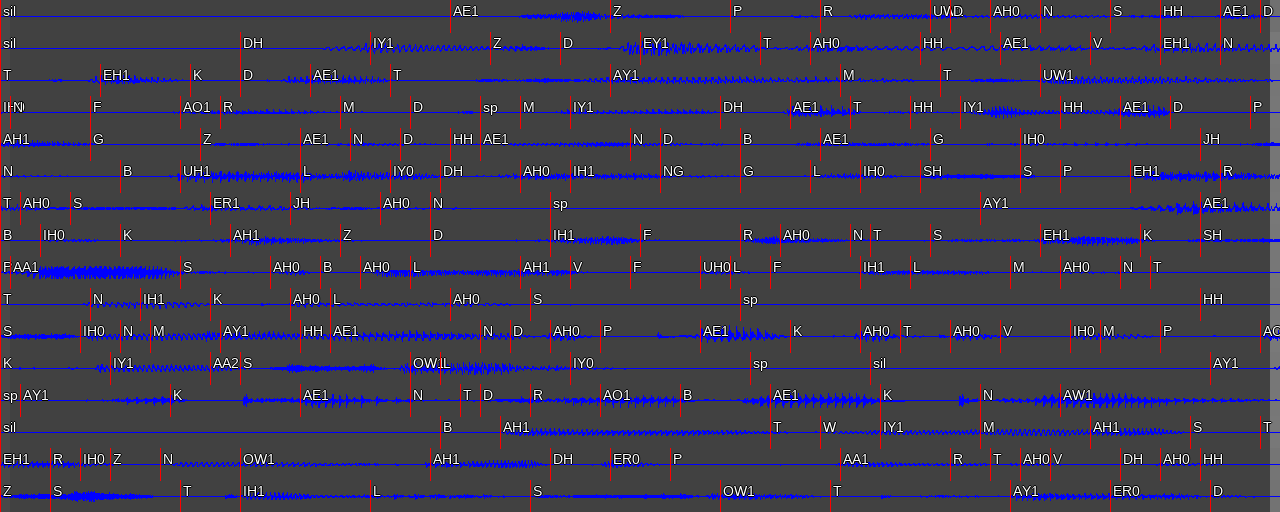

In [4]:
batchData, importance, phone_align, id_to_phone = load("/pio/gluster/i273233/checkpoints/smart/ls100_cpcctc/5_ar_normal_window_13_loss_001/capture/60", smartpoolingInAR=True)
visualize(batchData, importance, phone_align, id_to_phone)

In [6]:
importance[0,10]

tensor(0.2564)